# Experiment 6:
## Reconstruction with dithering, impact of the dithering/regularization parameter

This experiment shows the behaviour of the regularized reconstruction method with dithering when varying the dithering/regularization parameter using the following structural assumptions: 
- Sparsity in standard basis and
- Generative model.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

from torch.utils.data import DataLoader;
import torchvision;

import pickle;

import time;
import random;
import math;

from IPython.display import clear_output;


import MNIST_utils as MNIST;
import MNIST_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization

In [2]:
(train_data, test_data), (train_loader, test_loader) = MNIST.load_dataset();

noise = 0.1;
mspace_standard = [5000, 10000, 20000 , 40000];
mspace_gen = [250, 500, 1000];
lambda_space = np.linspace(0.01, 50, 26);

sparsity_standard = 150;

im_nums = 5;

# Standard basis

im: 0, m: 5000
im: 0, m: 10000
im: 0, m: 20000
im: 0, m: 40000
im: 1, m: 5000
im: 1, m: 10000
im: 1, m: 20000
im: 1, m: 40000
im: 2, m: 5000
im: 2, m: 10000
im: 2, m: 20000
im: 2, m: 40000
im: 3, m: 5000
im: 3, m: 10000
im: 3, m: 20000
im: 3, m: 40000
im: 4, m: 5000
im: 4, m: 10000
im: 4, m: 20000
im: 4, m: 40000


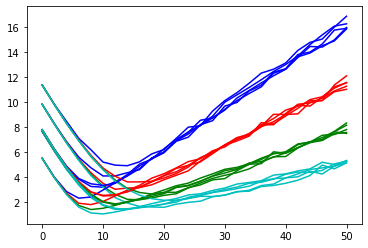

In [3]:
def experiment(x_true, m, noise, lamb, repetitions = 3):
    accum = 0.0;
    for i in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);      

        projector = lambda x : sparsity.HT(x, sparsity_standard);

        accum += MNIST.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 1, iterations = 100)[1];
    return accum/repetitions;


results = [[() for im in range(im_nums)] for m in mspace_standard];

utils.reset_seeds();
for im in range(im_nums):
    x_true = MNIST.getImageAsVector(test_loader, im);
    for j in range(len(mspace_standard)):
        m = mspace_standard[j];
        acc = [experiment(x_true, m, noise, lamb) for lamb in lambda_space];
        results[j][im] = acc;
        print("im: "+str(im) + ", m: " + str(m));

for im in range(im_nums):
    for j in range(len(mspace_standard)):
        if j == 0:
            col = 'b';
        elif j == 1:
            col = 'r';
        elif j == 2:
            col = 'g'
        else:
            col = 'c';
        plt.plot(lambda_space, results[j][im], c = col);

In [4]:
utils.saveData(results, "results_data/dithering_varying_m_sparse.data");

In [3]:
results_sparse = utils.loadData("results_data/dithering_varying_m_sparse.data");

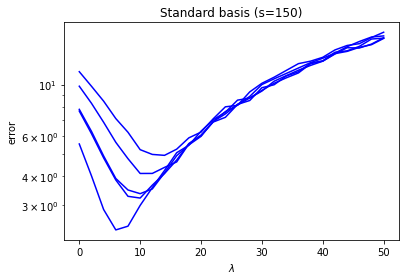

In [17]:
plt.yscale('log');
for i in range(5):
    for j in range(1):
        if j == 0:
            col = 'b';
        elif j == 1:
            col = 'r';
        elif j == 2:
            col = 'g'
        else:
            col = 'c';
        plt.plot(lambda_space, results_sparse[j][i], c = col);

plt.xlabel(r"$\lambda$");
plt.ylabel("error");
plt.title("Standard basis (s=150)");
plt.savefig("results_images/dithering_varying_lambda_sparsity.png", dpi=200);

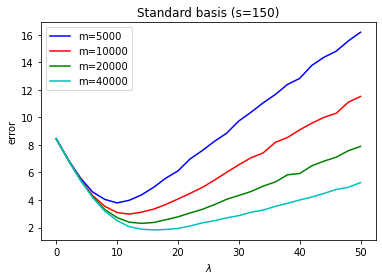

In [11]:
for j in range(len(mspace_standard)):
    if j == 0:
        col = 'b';
    elif j == 1:
        col = 'r';
    elif j == 2:
        col = 'g'
    else:
        col = 'c';
    plt.plot(lambda_space, np.mean(results_sparse[j],axis=0), c = col);
    
plt.title("Standard basis (s=150)");
plt.xlabel(r'$\lambda$');
plt.ylabel('error');
plt.legend(["m=5000","m=10000","m=20000","m=40000"])
plt.savefig("results_images/dithering_varying_lambda_sparsity_mean.png", dpi=200);

# Generative model

In [7]:
utils.reset_seeds();
_, autoEncoder = generative.createNetwork(3, 100);
generative.trainNetwork(autoEncoder, train_loader);

projector = lambda x : generative.project(x, autoEncoder , num_epochs = 50, learning_rate = 0.001);

C:\Users\jever\anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	 Train_loss: 1.069325
Epoch: 2 	 Train_loss: 0.498542
Epoch: 3 	 Train_loss: 0.370502
Epoch: 4 	 Train_loss: 0.312300
Epoch: 5 	 Train_loss: 0.281547
Epoch: 6 	 Train_loss: 0.260119
Epoch: 7 	 Train_loss: 0.243736
Epoch: 8 	 Train_loss: 0.231814
Epoch: 9 	 Train_loss: 0.222426
Epoch: 10 	 Train_loss: 0.214850
Epoch: 11 	 Train_loss: 0.207706
Epoch: 12 	 Train_loss: 0.202160
Epoch: 13 	 Train_loss: 0.197265
Epoch: 14 	 Train_loss: 0.192909
Epoch: 15 	 Train_loss: 0.188500
Epoch: 16 	 Train_loss: 0.183898
Epoch: 17 	 Train_loss: 0.179991
Epoch: 18 	 Train_loss: 0.175919
Epoch: 19 	 Train_loss: 0.172831
Epoch: 20 	 Train_loss: 0.169244


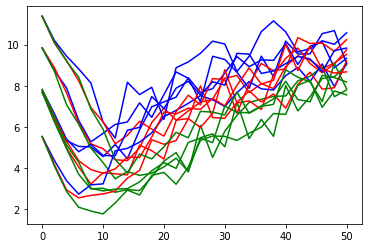

In [9]:
def experiment(x_true, m, sigma, lamb, repetitions = 3):
    accum = 0.0;
    for i in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);

        accum += MNIST.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 0.2, iterations = 50)[1];
    return accum/repetitions;

results = [[() for im in range(im_nums)] for m in mspace_gen];

utils.reset_seeds();
for im in range(im_nums):
    x_true = MNIST.getImageAsVector(test_loader, im);
    for j in range(len(mspace_gen)):
        m = mspace_gen[j];
        acc = [experiment(x_true, m, noise, lamb) for lamb in lambda_space];
        results[j][im] = acc;
        print("im: "+str(im) + ", m: " + str(m));

for im in range(im_nums):
    for j in range(len(mspace_gen)):
        if j == 0:
            col = 'b';
        elif j == 1: 
            col = 'r';
        elif j == 2:
            col = 'g'
        else:
            col = 'c';
        plt.plot(lambda_space, results[j][im], c = col);
        
utils.saveData(results, "results_data/dithering_varying_m_gen.data");

In [12]:
results_generative = utils.loadData("results_data/dithering_varying_m_gen.data");

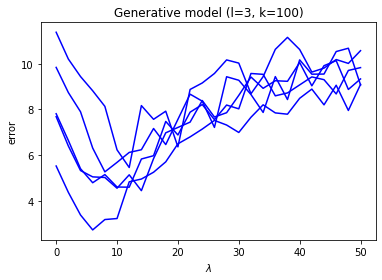

In [13]:
#plt.yscale('log');
for i in range(im_nums):
    for j in range(1):
        if j == 0:
            col = 'b';
        elif j == 1:
            col = 'r';
        elif j == 2:
            col = 'g'
        plt.plot(lambda_space, results_generative[j][i], c = col);

plt.xlabel(r"$\lambda$");
plt.ylabel("error");
plt.title("Generative model (l=3, k=100)");
plt.savefig("results_images/dithered_generative_optimal_lambda.png", dpi=200);

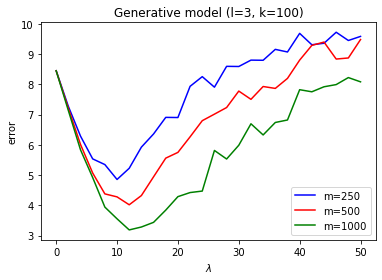

In [16]:
for j in range(len(mspace_gen)):
    if j == 0:
        col = 'b';
    elif j == 1:
        col = 'r';
    elif j == 2:
        col = 'g'
    else:
        col = 'c';
    plt.plot(lambda_space, np.mean(results_generative[j],axis=0), c = col);
    
plt.xlabel(r"$\lambda$");
plt.ylabel("error");
plt.title("Generative model (l=3, k=100)");
plt.legend(["m=250","m=500","m=1000"]);
plt.savefig("results_images/dithered_generative_optimal_lambda_mean.png", dpi=200);

# Optimal lambda 

# Standard basis

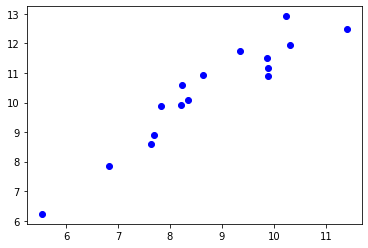

In [14]:
def experiment(x_true, m, noise, lamb, repetitions = 3):
    accum = 0.0;
    for i in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);      

        projector = lambda x : sparsity.HT(x, sparsity_standard);

        accum += MNIST.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 1, iterations = 100)[1];
    return accum/repetitions;

# Ternary search
def FindOptimalReg(x_true, m, noise, eps = 0.2):
    _min = 1.0;
    _max = 20.0;
    
    while (_max-_min) > eps:
        _m1 = (_max - _min)/3.0 + _min;
        _m2 = (_max - _min)*(2.0/3.0) + _min;
        _m1_v = experiment(x_true, m, noise, _m1);
        _m2_v = experiment(x_true, m, noise, _m2);
        if _m1_v < _m2_v:
            _max = _m2;
        else:
            _min = _m1;
    
    return (_max-_min)/2.0 + _min;

m = 5000;

data_norm = [];
data_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data_norm.append(_norm);
    data_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.show();

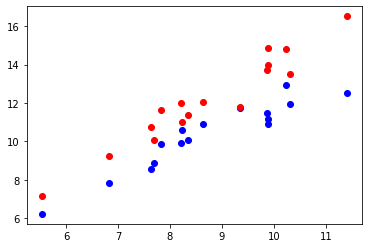

In [15]:
m = 10000;

data2_norm = [];
data2_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data2_norm.append(_norm);
    data2_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.scatter(data2_norm, data2_lambda, c='r');
    plt.show();

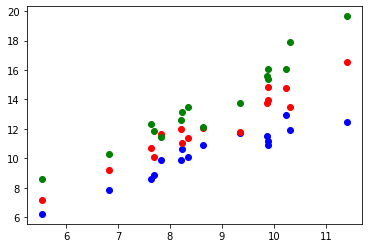

In [16]:
m = 20000;

data3_norm = [];
data3_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data3_norm.append(_norm);
    data3_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.scatter(data2_norm, data2_lambda, c='r');
    plt.scatter(data3_norm, data3_lambda, c='g');
    plt.show();

In [17]:
utils.saveData((data_norm, data_lambda,data2_norm, data2_lambda,data3_norm, data3_lambda), "results_data/optimal_lambda_sparsity.data")

In [18]:
(data_norm, data_lambda,data2_norm, data2_lambda,data3_norm, data3_lambda) = utils.loadData("results_data/optimal_lambda_sparsity.data");

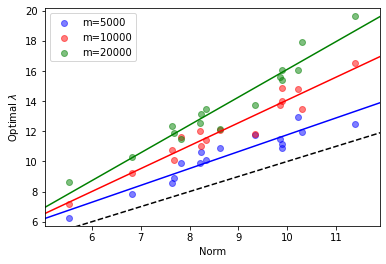

In [27]:
plt.plot([0,20],[0,20], 'k--');
plt.scatter(data_norm, data_lambda, alpha = 0.5, c='b', label="m=5000");
plt.scatter(data2_norm, data2_lambda, alpha = 0.5, c='r', label="m=10000");
plt.scatter(data3_norm, data3_lambda, alpha = 0.5, c='g', label="m=20000");


m, b = np.polyfit(data_norm, data_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='b');

m, b = np.polyfit(data2_norm, data2_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='r');

m, b = np.polyfit(data3_norm, data3_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='g');


plt.xlim([min(np.min(data_norm),np.min(data2_norm),np.min(data3_norm))-0.5,max(np.max(data_norm),np.max(data2_norm),np.max(data3_norm))+0.5]);
plt.ylim([min(np.min(data_lambda),np.min(data2_lambda),np.min(data3_lambda))-0.5,max(np.max(data_lambda),np.max(data2_lambda),np.max(data3_lambda))+0.5]);
plt.legend();
plt.xlabel("Norm");
plt.ylabel(r"Optimal $\lambda$");
plt.savefig("results_images/dithered_sparsity_optimal_lambda_norm.png", dpi=200);

# Generative

15


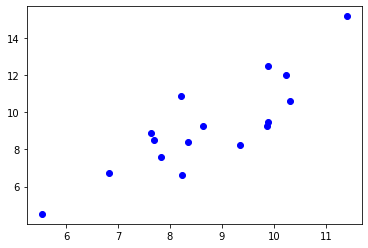

In [20]:
projector = lambda x : generative.project(x, autoEncoder , num_epochs = 50, learning_rate = 0.001);

def experiment(x_true, m, noise, lamb, repetitions = 3):
    accum = 0.0;
    for i in range(repetitions):
        A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);    
        accum += MNIST.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 0.2, iterations = 50)[1];
    return accum/repetitions;

# Ternary search
def FindOptimalReg(x_true, m, noise, eps = 0.2):
    _min = 1.0;
    _max = 20.0;
    
    while (_max-_min) > eps:
        _m1 = (_max - _min)/3.0 + _min;
        _m2 = (_max - _min)*(2.0/3.0) + _min;
        _m1_v = experiment(x_true, m, noise, _m1);
        _m2_v = experiment(x_true, m, noise, _m2);
        if _m1_v < _m2_v:
            _max = _m2;
        else:
            _min = _m1;
    
    return (_max-_min)/2.0 + _min;


m = 250;

data_norm = [];
data_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data_norm.append(_norm);
    data_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    print(i);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.show();

15


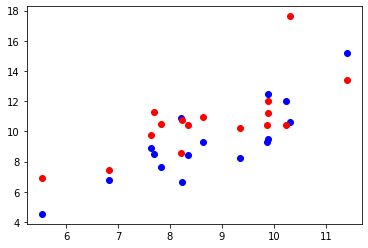

In [22]:
m = 500;

data2_norm = [];
data2_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data2_norm.append(_norm);
    data2_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    print(i);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.scatter(data2_norm, data2_lambda, c='r');
    plt.show();

15


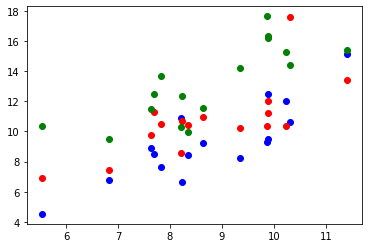

In [23]:
m = 1000;

data3_norm = [];
data3_lambda = [];

utils.reset_seeds();
for i in range(16):
    x_true = MNIST.getImageAsVector(test_loader, i);
    _norm = linalg.norm(x_true);
    _opt_lambda = FindOptimalReg(x_true, m, noise);
    data3_norm.append(_norm);
    data3_lambda.append(_opt_lambda);
    
    clear_output(wait=True);
    print(i);
    plt.scatter(data_norm, data_lambda, c='b');
    plt.scatter(data2_norm, data2_lambda, c='r');
    plt.scatter(data3_norm, data3_lambda, c='g');
    plt.show();

In [24]:
utils.saveData((data_norm, data_lambda,data2_norm, data2_lambda,data3_norm, data3_lambda), "results_data/optimal_lambda_generative.data")

In [28]:
(data_norm, data_lambda,data2_norm, data2_lambda,data3_norm, data3_lambda) = utils.loadData("results_data/optimal_lambda_generative.data");

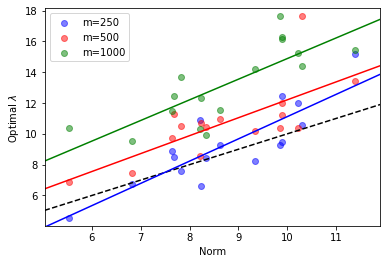

In [30]:
plt.plot([0,20],[0,20], 'k--');
plt.scatter(data_norm, data_lambda, alpha = 0.5, c='b', label="m=250");
plt.scatter(data2_norm, data2_lambda, alpha = 0.5, c='r', label="m=500");
plt.scatter(data3_norm, data3_lambda, alpha = 0.5, c='g', label="m=1000");



m, b = np.polyfit(data_norm, data_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='b');

m, b = np.polyfit(data2_norm, data2_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='r');

m, b = np.polyfit(data3_norm, data3_lambda, 1);
plt.plot([0,20], [b, b + m*20], c='g');



plt.xlim([min(np.min(data_norm),np.min(data2_norm),np.min(data3_norm))-0.5,max(np.max(data_norm),np.max(data2_norm),np.max(data3_norm))+0.5]);
plt.ylim([min(np.min(data_lambda),np.min(data2_lambda),np.min(data3_lambda))-0.5,max(np.max(data_lambda),np.max(data2_lambda),np.max(data3_lambda))+0.5]);
plt.legend();
plt.xlabel("Norm");
plt.ylabel(r"Optimal $\lambda$");
plt.savefig("results_images/dithered_generative_optimal_lambda_norm.png", dpi=200);